## Clustering

Let's now retrieve the embeddings from the chromadb and perform clustering on them.

In [50]:
import chromadb

client = chromadb.PersistentClient(path="./chroma_db")
collection = client.get_collection("nomic_clustering3")

### We will use the KMeansConstrained algorithm to perform clustering. 
This algorithm is a modification of the KMeans algorithm that allows to specify the minimum and maximum size of each cluster. 
This is useful to avoid having clusters with too few or too many elements.

In [51]:
from k_means_constrained import KMeansConstrained

model = KMeansConstrained(n_clusters=6, size_min=140, size_max=240,
                          n_init=100, max_iter=500, random_state=20)

### Let's retrieve the embeddings and the words from the chromadb and create a dataframe with them.


In [52]:
import pandas as pd

# Retrieve the embeddings and the words
words = (collection.get(include=["embeddings", "documents"])['documents'])
embeddings = (collection.get(include=["embeddings", "documents"])['embeddings'])
# Create a dataframe with the embeddings and the words
clustering_df = pd.DataFrame({'embedding': embeddings})
clustering_df['word'] = words
clustering_df

,embedding,word
0,"[-0.000911712646484375, -0.007648468017578125,...",Existence
1,"[0.006107330322265625, 0.0400390625, -0.014945...",Inexistence
2,"[0.034515380859375, 0.019073486328125, -0.0277...",Cessation
3,"[0.0287322998046875, 0.0013332366943359375, -0...",Relation
4,"[0.0217742919921875, 0.032012939453125, -0.025...",Acquisition
...,...,...
1054,"[0.006465911865234375, 0.02752685546875, -0.02...",Commission
1055,"[0.0287017822265625, 0.012420654296875, -0.002...",Abrogation
1056,"[0.016265869140625, 0.030792236328125, -0.0295...",Resignation
1057,"[0.05120849609375, 0.0181121826171875, -0.0064...",Consignee


We will use the embeddings to fit the model, and then we will add the cluster labels to the dataframe,
where we will use vstack to convert the list of embeddings into a matrix.

In [53]:
import numpy as np

matrix = np.vstack(clustering_df.embedding.values)
matrix.shape

(1059, 768)

We can now fit the model and add the cluster labels to the dataframe.

In [54]:
model.fit(matrix)
labels = model.labels_
clustering_df["Cluster"] = labels

We can now visualize the clusters in a 2D space using t-SNE.

Text(0.5, 1.0, 'Clusters identified visualized in language 2d using t-SNE')

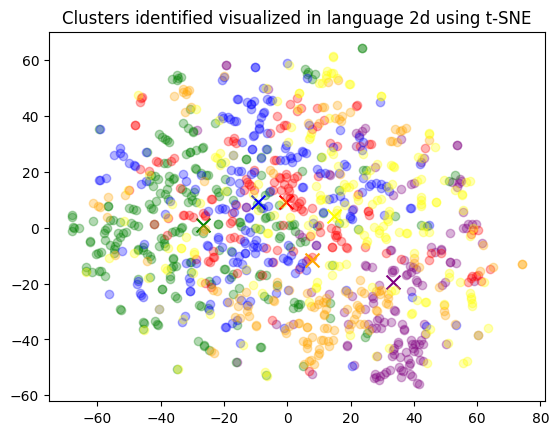

In [55]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

tsne = TSNE(n_components=2, perplexity=15, random_state=42, init="random", learning_rate=200)
vis_dims2 = tsne.fit_transform(matrix)

x = [x for x, y in vis_dims2]
y = [y for x, y in vis_dims2]

for category, color in enumerate(["purple", "green", "red", "blue", "orange", "yellow"]):
    xs = np.array(x)[clustering_df.Cluster == category]
    ys = np.array(y)[clustering_df.Cluster == category]
    plt.scatter(xs, ys, color=color, alpha=0.3)

    avg_x = xs.mean()
    avg_y = ys.mean()

    plt.scatter(avg_x, avg_y, marker="x", color=color, s=100)
plt.title("Clusters identified visualized in language 2d using t-SNE")

Let's now count the number of elements in each cluster.

In [56]:
clustering_df.Cluster.value_counts()

Cluster
1    240
3    201
5    193
2    145
0    140
4    140
Name: count, dtype: int64

### Let's now try and give a name to each cluster based on the words that are in it.

For this task we will use the latest mistral-v.0.2 LLM model self-hosted using Ollama.
More specifically, we will give the model the words in each cluster and ask it to give a category name similar to the 
class names of of the roget thesaurus. 
In order to use the model, we will use the `ChatOllama` class from the `langchain_community` library.
We will set the temperature to 0.0 to get the most likely categories and we will use the GPU if it is available.

In [ ]:
from langchain_community.chat_models import ChatOllama
import torch

llm_model = 'mistral'
device = "cuda" if torch.cuda.is_available() else "cpu"

# We set the temperature to 0.0 to get the most likely categories and we use the mistral model
llm = ChatOllama(model=llm_model, temperature=0.0, device=device)

Next we will define the prompt that we will use to get the categories from the model.

In [ ]:
from langchain_core.prompts import ChatPromptTemplate

prompt = ChatPromptTemplate.from_template(
    "Provide a category that classifies all these words about what they express (only into one category) : {words}"
    "similar with the naming of the following categories: {categories} along with a small explanation of why you chose to name the category in this way. At the end of the explanation, please write the category again inside <<>>. For example: <<category>>")

Then we will create a chain that will use the prompt, the llm model and the output parser to get the categories from the model.

In [ ]:
from langchain_core.output_parsers import StrOutputParser

chain = prompt | llm | StrOutputParser()

Now let us get the words along with their classes and division and sections from the json file we created earlier.

In [34]:
import json

with open("hierarchy.json", "r") as f:
    categories = json.load(f)

Let's convert the above into a dataframe.

In [57]:
import pandas as pd


def json_to_df(categories, class_name=None, division_name='N/A'):
    df = pd.DataFrame()
    for key, value in categories.items():
        # Check if the current key is a class
        if 'divisions' in value and 'sections' in value:
            class_df = json_to_df(value['divisions'], class_name=key)
            section_df = json_to_df(value['sections'], class_name=key)
            df = pd.concat([df, class_df, section_df], ignore_index=True)
        elif isinstance(value, dict):  # This is a division or section
            sub_df = json_to_df(value, class_name=class_name, division_name=key)
            df = pd.concat([df, sub_df], ignore_index=True)
        else:  # This is the actual list of words
            for word in value:
                new_row = pd.DataFrame({
                    "word": [word],
                    "class": [class_name],
                    "division": [division_name],
                    "section": [key],

                })
                df = pd.concat([df, new_row], ignore_index=True)
    return df


categories_df = json_to_df(categories)

# Displaying the first few rows of the DataFrame
categories_df

,word,class,division,section
0,Existence,WORDS EXPRESSING ABSTRACT RELATIONS,N/A,EXISTENCE
1,Inexistence,WORDS EXPRESSING ABSTRACT RELATIONS,N/A,EXISTENCE
2,Substantiality,WORDS EXPRESSING ABSTRACT RELATIONS,N/A,EXISTENCE
3,Unsubstantiality,WORDS EXPRESSING ABSTRACT RELATIONS,N/A,EXISTENCE
4,Intrinsicality,WORDS EXPRESSING ABSTRACT RELATIONS,N/A,EXISTENCE
...,...,...,...,...
1052,Clergy,WORDS RELATING TO THE SENTIENT AND MORAL POWERS,N/A,RELIGIOUS AFFECTIONS
1053,Laity,WORDS RELATING TO THE SENTIENT AND MORAL POWERS,N/A,RELIGIOUS AFFECTIONS
1054,Rite,WORDS RELATING TO THE SENTIENT AND MORAL POWERS,N/A,RELIGIOUS AFFECTIONS
1055,Canonicals,WORDS RELATING TO THE SENTIENT AND MORAL POWERS,N/A,RELIGIOUS AFFECTIONS


In [63]:
# Merge the df with the categories_df
df_both = clustering_df.merge(categories_df, on="word", how="inner")
df_both

,embedding,word,Cluster,class,division,section
0,"[-0.000911712646484375, -0.007648468017578125,...",Existence,0,WORDS EXPRESSING ABSTRACT RELATIONS,N/A,EXISTENCE
1,"[0.006107330322265625, 0.0400390625, -0.014945...",Inexistence,0,WORDS EXPRESSING ABSTRACT RELATIONS,N/A,EXISTENCE
2,"[0.034515380859375, 0.019073486328125, -0.0277...",Cessation,5,WORDS EXPRESSING ABSTRACT RELATIONS,N/A,CHANGE
3,"[0.0287322998046875, 0.0013332366943359375, -0...",Relation,1,WORDS EXPRESSING ABSTRACT RELATIONS,N/A,RELATION
4,"[0.0217742919921875, 0.032012939453125, -0.025...",Acquisition,1,WORDS RELATING TO THE VOLUNTARY POWERS,sections,POSSESSIVE RELATIONS
...,...,...,...,...,...,...
1076,"[0.006465911865234375, 0.02752685546875, -0.02...",Commission,1,WORDS RELATING TO THE VOLUNTARY POWERS,sections,GENERAL INTERSOCIAL VOLITION
1077,"[0.0287017822265625, 0.012420654296875, -0.002...",Abrogation,5,WORDS RELATING TO THE VOLUNTARY POWERS,sections,GENERAL INTERSOCIAL VOLITION
1078,"[0.016265869140625, 0.030792236328125, -0.0295...",Resignation,2,WORDS RELATING TO THE VOLUNTARY POWERS,sections,GENERAL INTERSOCIAL VOLITION
1079,"[0.05120849609375, 0.0181121826171875, -0.0064...",Consignee,5,WORDS RELATING TO THE VOLUNTARY POWERS,sections,GENERAL INTERSOCIAL VOLITION


Having the above setup, we can now get the categories for each cluster.

The following code was inspired by the following [OpenAI notebook](https://cookbook.openai.com/examples/clustering).

The idea is to use the words in each cluster to get the categories from the model
 and we will show 20 words from each cluster after the explanation about why the naming of the category was chosen,
 but here we are using the mistral model instead of the GPT-4 model through the langchain_community library.

In our case we will use the words in each cluster to get the categories from the model.
 and we will show 20 words from each cluster after the explanation about why the naming of the category was chosen.
 
More specifically, we will write the name of the category in the following format: <<category>> at the end of the explanation
in order to easily get it through regex.

In [65]:
import re

# Reading words belonging to each cluster
num_words = 10

# Initialize the list of classes
classes = []

for i in range(6):
    print(f"Cluster {i} Theme:", end=" ")

    words = ",".join(
        df_both[df_both.Cluster == i]["word"]
        .values
    )

    response = chain.invoke({"words": words, "categories": categories})
    print(response)

    # Extracting the categories from the response
    pattern = r'<<([^>]*)>>'
    matches = re.finditer(pattern, response)
    # Append extracted class name to the list of classes
    classes.append([match.group(1) for match in matches])
    sample_cluster_rows = df_both[df_both.Cluster == i]['word'].sample(num_words, random_state=42)
    for j in range(num_words):
        print(sample_cluster_rows.iloc[j], end=", ")
    print()

    print("-" * 100)

Cluster 0 Theme: 

NameError: name 'chain' is not defined

Let's now see the classes that were extracted from the model.

In [ ]:
classes

We can see that the model was able to give a category to each cluster based on the words that are in it.

# ! Write about conclusions and comparisons with the roget classes

Now having done with the naming of the clusters, we can try and match the extracted classes with the classes from the roget thesaurus.

Let's start by creating a function that will take the extracted classes and the roget classes and will return the most similar roget class for each extracted class
by identifying the closest words to each cluster's centroid.

In [ ]:
def clustering_details(model, maximum_value, df_both, categories):
    # Get the cluster labels
    labels = model.labels_

    # Initialize a dictionary to store words in each cluster
    words_in_clusters = {i: [] for i in range(len(set(labels)))}
    # Associate each word with its corresponding cluster label
    for word, label in zip(df_both['word'].tolist(), df_both['Cluster'].tolist()):
        words_in_clusters[label].append(word)

    # Print words in each cluster
    for cluster, words_in in words_in_clusters.items():
        print(f"Cluster {cluster}: {words_in}")

    # Print the number of words in each cluster
    unique, counts = np.unique(labels, return_counts=True)
    print(dict(zip(unique, counts)))

    # Get the cluster centers
    centroids = model.cluster_centers_

    total_count = []

    # Create a mapping for categories
    category_mapping = {cat: idx for idx, cat in enumerate(categories.keys())}

    # Find the closest word to each centroid
    for i, centroid in enumerate(centroids):
        # Filter embeddings belonging to the current cluster
        cluster_embeddings = np.vstack(df_both['embedding'][labels == i])

        # Check and adjust shapes
        if cluster_embeddings.shape[1] != centroid.shape[0]:
            print(
                f"Dimension mismatch: Embeddings have {cluster_embeddings.shape[1]} features, but centroid has {centroid.shape[0]} features.")
            continue  # Skip this iteration

        # Calculate the distance between the centroid and embeddings in the cluster
        distances = np.linalg.norm(cluster_embeddings - centroid, axis=1)

        # Find the indices of the closest embeddings
        closest_indices = np.argsort(distances)[:maximum_value]

        # Retrieve the corresponding words
        closest_words = df_both['word'].iloc[np.where(labels == i)[0][closest_indices]].tolist()

        # Print the closest words to the centroid
        print(f"Closest words to centroid {i}: {closest_words}")

        # Initialize count
        count = [0] * len(category_mapping)

        # Check each word in the closest words
        for word in closest_words:
            for category, content in categories.items():
                # Check in divisions first
                for division_content in content.get('divisions', {}).values():
                    if word in division_content.get('sections', {}).values():
                        count[category_mapping[category]] += 1
                        break
                else:
                    # Check in sections
                    if word in content.get('sections', {}).values():
                        count[category_mapping[category]] += 1
                        break

        total_count.append(count)

    return total_count

After that, we will define a function that matches the clusters to the classes.

In [ ]:
def match_clusters_to_classes(total_count):
    relation = []

    # Convert total_count to a numpy array for efficient operations
    total_count_array = np.array(total_count)

    for _ in range(len(total_count_array)):
        # Find the index of the maximum value in the 2D array
        max_pos, max_index = np.unravel_index(total_count_array.argmax(), total_count_array.shape)
        max_val = total_count_array[max_pos, max_index]

        # Add the cluster and class with the maximum value to the relation list
        relation.append([max_pos, max_index])

        # Set all values in the column of the found max value to -1
        total_count_array[:, max_index] = -1
        # Set all values in the row of the found max value to -1
        total_count_array[max_pos, :] = -1

    return relation


Lastly, we will define a function that remaps the labels using the relation list we get from the previous function.

In [ ]:
def remap(labels, relation):
    # Convert the relation list to a dictionary for fast lookup
    relation_dict = {cluster: cls for cluster, cls in relation}

    # Remap the labels using the relation dictionary
    remapped_labels = [relation_dict.get(label, label) for label in labels]

    return remapped_labels

Now we can use the above functions to get the most similar roget class for each extracted class.

In [ ]:
# Set the maximum value to find the closest words to the centroid
MAX_VALUE = 240
total_count = clustering_details(model, MAX_VALUE, df_both, categories)
relation = match_clusters_to_classes(total_count)
predicted_labels = remap(labels, relation)

With the above setup, we can now compare the extracted classes with the roget classes
by doing a classification report as well as a confusion matrix on the predicted labels and the roget classes.
to see how well the extracted classes match the roget classes.

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

# Print the classification report
print(classification_report(df_both['class'], predicted_labels))

In [ ]:
# Print the confusion matrix
print(confusion_matrix(df_both['class'], predicted_labels))